In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import deque
from heapq import heappop, heappush
from functools import partial

from path_search_visualization import animate_search

%matplotlib widget

In [2]:
DEFAULT_COLOR = "#0064e1"

def graph_factory():

    node_positions = {
        "S": (0, 0),
        "A": (0, 2),
        "B": (1, 1),
        "C": (2, 3),
        "D": (3, 1),
        "E": (3, 2),
        "G": (4, 3),
    }

    node_colors = {node: DEFAULT_COLOR for node in node_positions.keys()}

    node_attrs = {"positions": node_positions, "colors": node_colors}

    G = nx.Graph()

    G.add_weighted_edges_from(
        [
            ("S", "A", 2),
            ("S", "B", 4),
            ("A", "C", 2),
            ("B", "C", 1),
            ("C", "E", 4),
            ("B", "D", 1),
            ("D", "E", 2),
            ("E", "G", 5)
        ]
        )

    return G, node_attrs

## Graph traversal Algorithms

### Uninformed search
#### DFS and BFS

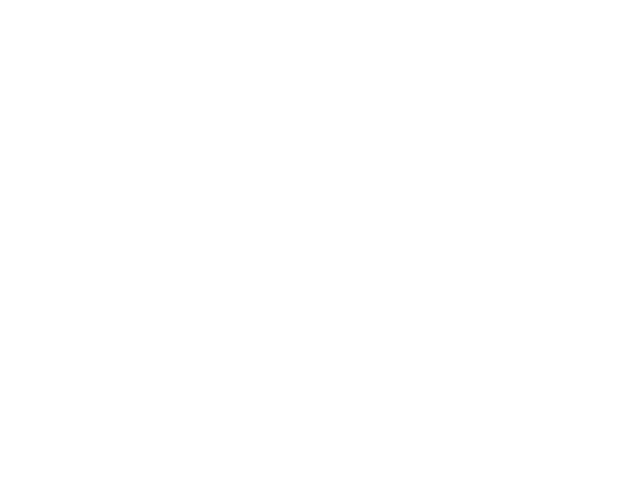

In [3]:
def dfs(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node]), reverse=True):
            if neighbor not in visited:
                q.appendleft(path + [neighbor])

    return []


G, node_attrs = graph_factory()

fig, ax = plt.subplots()
ax.axis("off")
explored_paths = dfs(G, "S", "G")
    
ani = animate_search(fig, ax, G, node_attrs["positions"], "DFS \n" + r"$S \rightarrow G$", explored_paths)
plt.show()

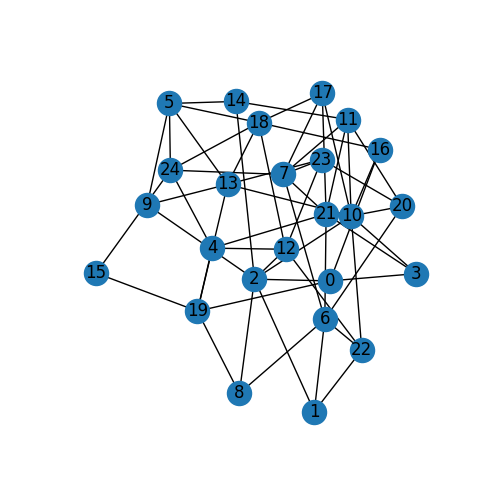

In [4]:
G = nx.erdos_renyi_graph(25, 0.2, seed=195)
positions = nx.spring_layout(G, seed=123)

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("off")
nx.draw_networkx(G, pos=positions, ax=ax)
plt.show()

In [5]:
start, end = 0, 5
explored_paths = dfs(G, start, end)

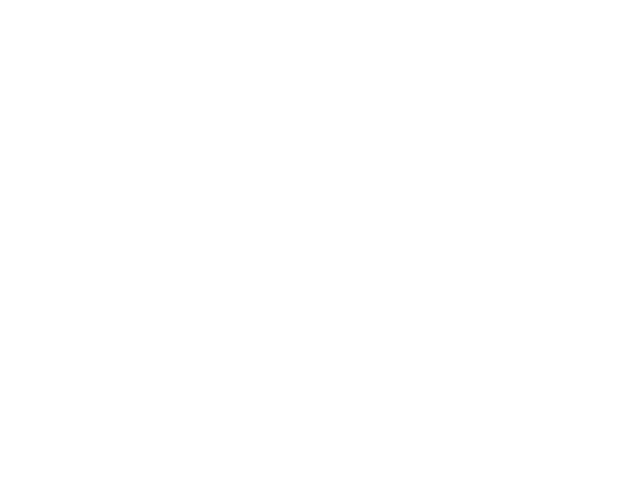

In [6]:
fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, "DFS\n" + rf"${start} \rightarrow {end}$", explored_paths, interval=500)
plt.show()

In [7]:
def bfs(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node])):
            if neighbor not in visited:
                q.append(path + [neighbor])

    return []

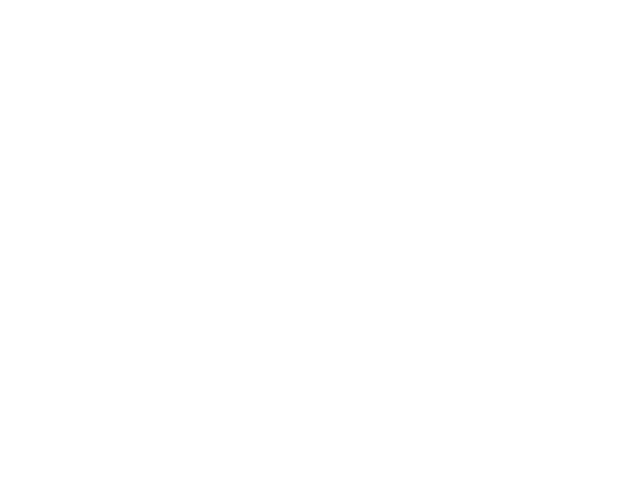

In [8]:
explored_paths = bfs(G, start, end)


fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, "BFS\n" + rf"${start} \rightarrow {end}$", explored_paths, interval=200)
plt.show()

## Using Heuristics
* **Admissible** Heuristics, the estimated distance is less or equal to the actual distance (useful for maps)
    $$H(x, G) \leq D(x, G)$$
* **Consistent** Heuristics,
    $$|H(x, G) - H(y, G)| \leq D(x, y)$$

### Hill Climbing
Sort the optimal next nodes by their cartesian distance to the end goal. as-crow-flies / straight line distance heuristic

In [9]:
def cartesian_distance(node_positions, end, node):
    node_end_vector  = node_positions[end] - node_positions[node]
    return np.sqrt((node_end_vector * node_end_vector).sum())
    

def hill_climbing(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    assert "heuristic" in kwargs, "Heuristic function F(end, node) is expected"
    heuristic = kwargs["heuristic"]
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node]), key=partial(heuristic, end), reverse=True):
            if neighbor not in visited:
                q.appendleft(path + [neighbor])

    return []

In [10]:
explored_paths_dfs = dfs(G, start, end)
explored_paths_hill_climbing = hill_climbing(G, start, end, heuristic=partial(cartesian_distance, positions))

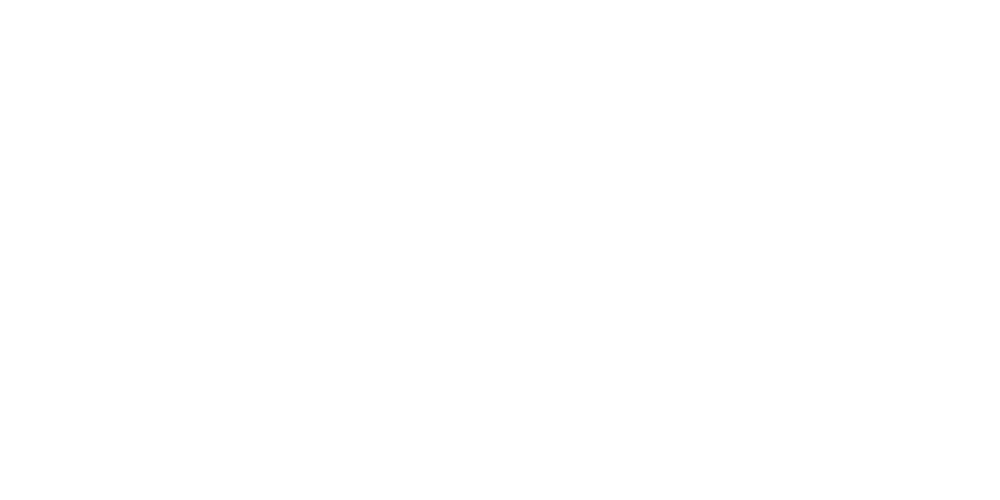

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_dfs = animate_search(fig, ax1, G, positions, "DFS\n" + rf"${start} \rightarrow {end}$", explored_paths_dfs, interval=500)

ax2.axis("off") 
ani_hill = animate_search(fig, ax2, G, positions, "Hill Climbing\n" + rf"${start} \rightarrow {end}$", explored_paths_hill_climbing, interval=1000)

plt.show()

### Beam Search
Follow the breadth first search level by level exploration but expands only the `w` best nodes and purges the rest.


In [12]:
def beam_search(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    assert "heuristic" in kwargs, "Heuristic function F(end, node) is expected"
    assert "w" in kwargs, "Beam width 'w' is expected"
    heuristic = kwargs["heuristic"]
    w = kwargs["w"]
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        beam_ind = 0
        for neighbor in sorted(list(G.adj[last_node]), key=partial(heuristic, end)):
            if not (beam_ind < w):
                continue
            if neighbor not in visited:
                q.append(path + [neighbor])
            beam_ind += 1
            

    return []

In [13]:
explored_paths_bfs = bfs(G, start, end)
explored_paths_beam_search = beam_search(G, start, end, heuristic=partial(cartesian_distance, positions), w=2)

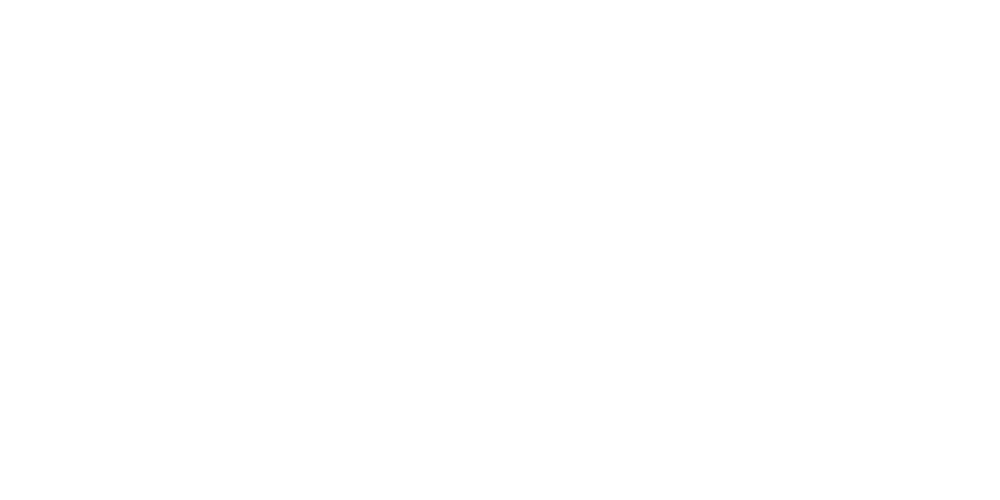

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_bfs = animate_search(fig, ax1, G, positions, "BFS\n" + rf"${start} \rightarrow {end}$", explored_paths_bfs, interval=200)

ax2.axis("off") 
ani_beam = animate_search(fig, ax2, G, positions, "Beam Search\n" + rf"${start} \rightarrow {end}$", explored_paths_beam_search, interval=200)

plt.show()

## Finding a path vs finding the optimal path

Until now dfs, bfs and their informed search adapted version content with finding one path between `start` and `end` but although for certain problems that might be usefull we can find ourselves wanting to compute the best possible path that solves the problem. We'll be concern about the `length` of the paths we find.

In [15]:
# this implementation will use the actual lenght of the path in future examples related to city travelling
# might be usefull to considerated weight[time] = length / allowed_speed
edge_labels = {}
for edge in G.edges():
    distance = cartesian_distance(positions, edge[1], edge[0])
    G.edges[edge]["weight"] = distance
    edge_labels[edge] = f"{distance:.2f}"

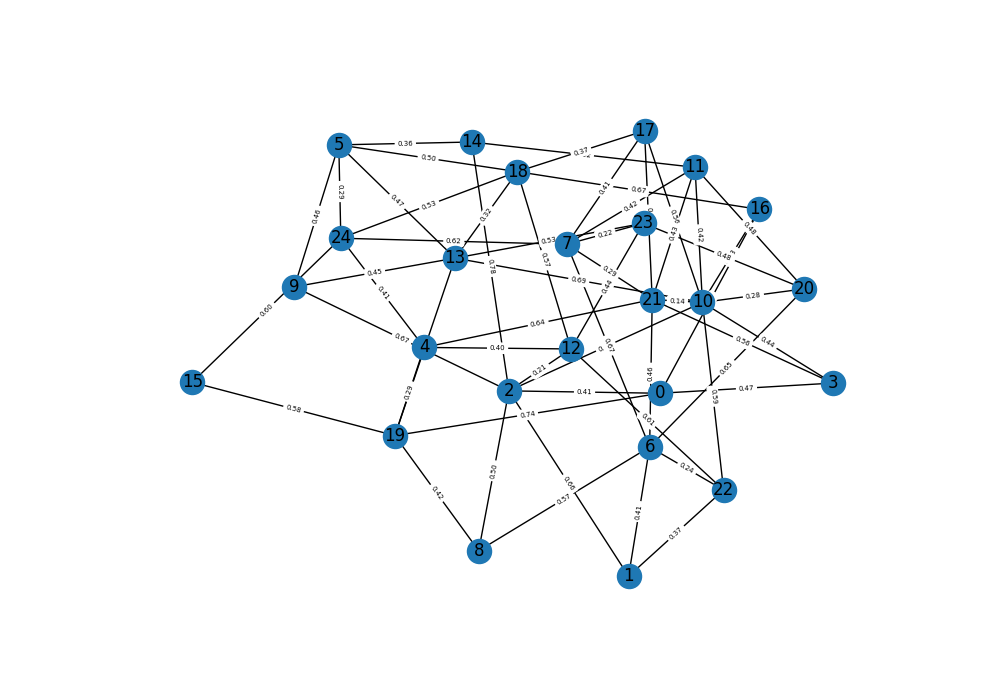

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.axis("off")
nx.draw_networkx(G, pos=positions, ax=ax)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=5, ax=ax)
plt.show()

In [17]:
def path_length(G, path):
    edges_list = [(a, b) for a, b in zip(path[:-1], path[1:])]
    return sum([G.edges[edge]["weight"] for edge in edges_list])

path_length(G, explored_paths_beam_search[-1])

1.5576184766972503

### Branch and Bound
Extend the path with the smallest accumulated length on the queue

In [18]:
def is_weighted_graph(G):
    for edge in G.edges():
        if "weight" not in G.edges[edge]:
            return False
    return True 

In [24]:
def branch_n_bound(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    assert is_weighted_graph(G), "Weighted Graph required for optimal path search"

    q = [(0, [start])]  # state: accumulated distance, path
    explored_paths = []
    extended = set()

    while q:
        acc_distance, path = heappop(q)
        last_node = path[-1]
        explored_paths.append(path)

        if last_node == end:
            return explored_paths
        
        if last_node in extended:
            continue

        extended.add(last_node)

        for neighbor in G.adj[last_node]:
            heappush(
                q,
                (acc_distance + G.edges[(last_node, neighbor)]["weight"], path + [neighbor])
                )

    return []

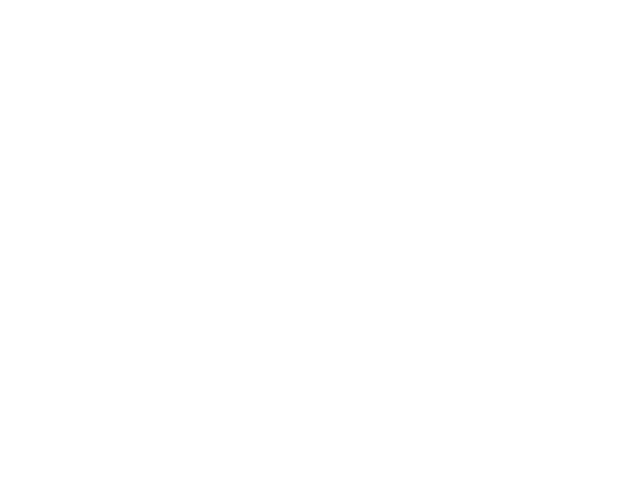

In [25]:
explored_paths_bnb = branch_n_bound(G, start, end)


fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, "Branch And Bound\n" + rf"${start} \rightarrow {end}$", explored_paths_bnb, interval=100)
plt.show()

Path Length: 1.54
Path Length: 1.56


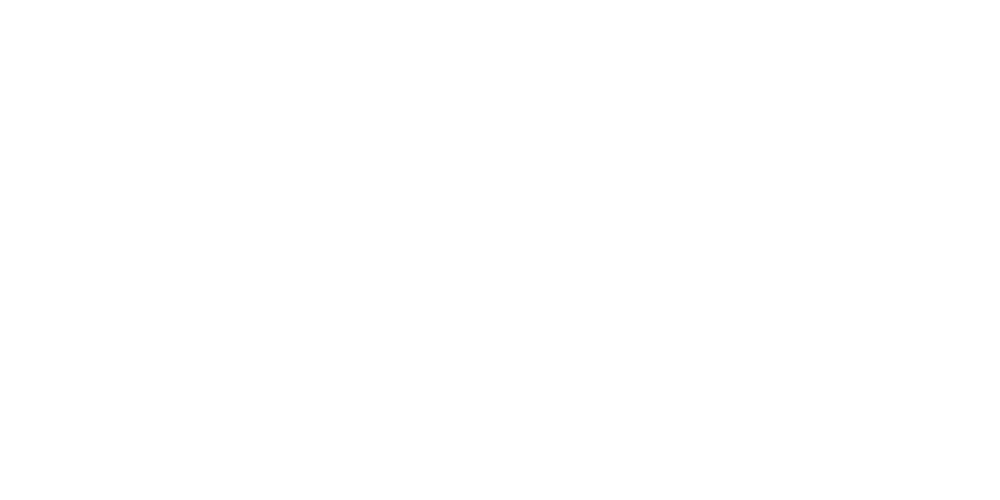

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_bnb = animate_search(fig, ax1, G, positions, "Branch And Bound\n" + rf"${start} \rightarrow {end}$", explored_paths_bnb, interval=200)

ax2.axis("off") 
ani_beam = animate_search(fig, ax2, G, positions, "Beam Search\n" + rf"${start} \rightarrow {end}$", explored_paths_beam_search, interval=200)

print(f"Path Length: {path_length(G, explored_paths_bnb[-1]):.2f}")
print(f"Path Length: {path_length(G, explored_paths_beam_search[-1]):.2f}")

plt.show()

## A*: Branch and Bound + Admissible Heuristic
In a 2d map an admissible heuristic is the cartesian distance, since the minimum distance between two points is the cartesian distance, the distance between nodes A and B will always be equal or larger.

In [27]:
def A_star(G, start, end, **kwargs):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    assert "heuristic" in kwargs, "Heuristic function F(end, node) is expected"
    heuristic = kwargs["heuristic"]

    q = [(0, 0, [start])]  # state: estimate distance, accumulated distance, path
    explored_paths = []
    extended = set()

    while q:
        estimate_distance, acc_distance, path = heappop(q)
        last_node = path[-1]
        explored_paths.append(path)

        if last_node == end:
            return explored_paths
        
        if last_node in extended:
            continue

        extended.add(last_node)

        for neighbor in G.adj[last_node]:
            heappush(
                q,
                (
                    acc_distance + G.edges[(last_node, neighbor)]["weight"] + heuristic(end, neighbor),
                    acc_distance + G.edges[(last_node, neighbor)]["weight"],
                    path + [neighbor])
                )

    return []

In [28]:
explored_paths_a_star = A_star(G, start, end, heuristic=partial(cartesian_distance, positions))

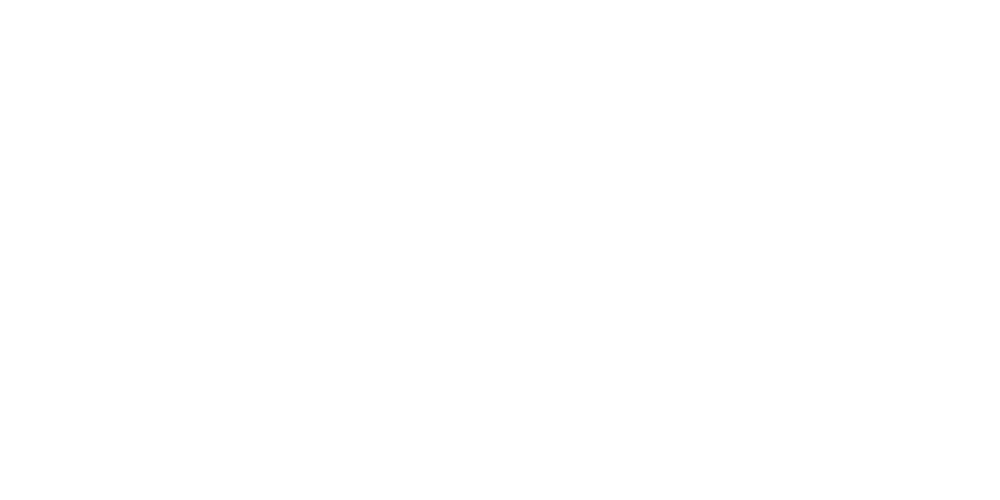

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_bnb = animate_search(fig, ax1, G, positions, "Branch And Bound\n" + rf"${start} \rightarrow {end}$", explored_paths_bnb, interval=200)

ax2.axis("off") 
ani_star = animate_search(fig, ax2, G, positions, r"$A^{*}$" + "\n" + rf"${start} \rightarrow {end}$", explored_paths_a_star, interval=200)

plt.show()

### Readme GIFs

In [30]:
import matplotlib.animation as animation

writer = animation.PillowWriter(
    fps=2,
    bitrate=1800,
)

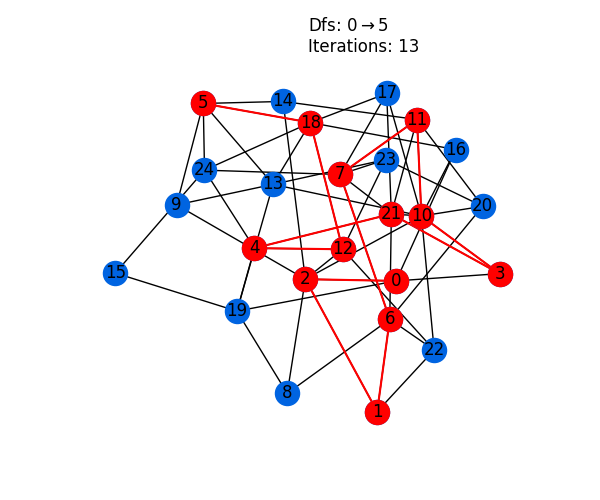

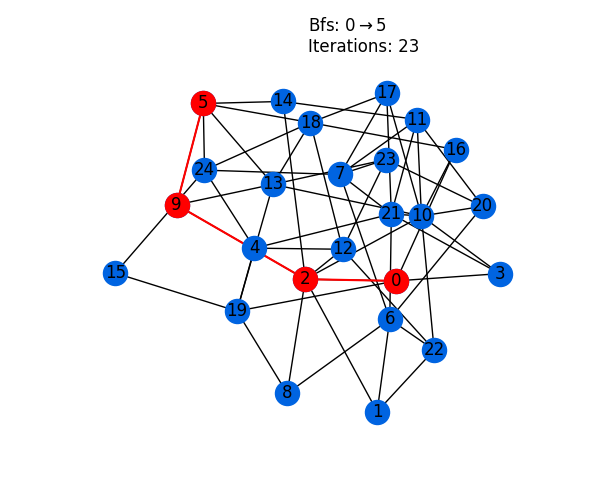

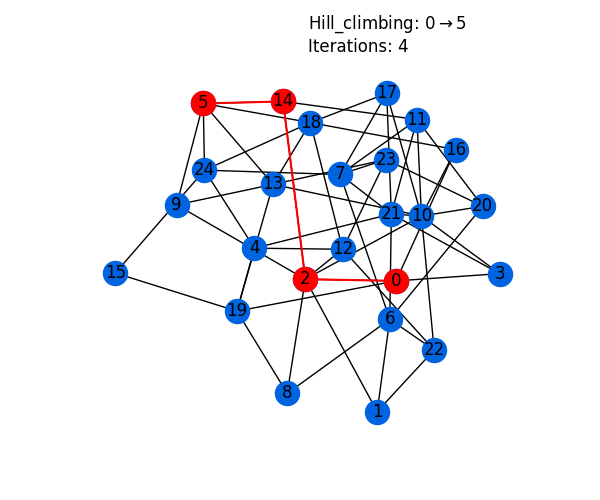

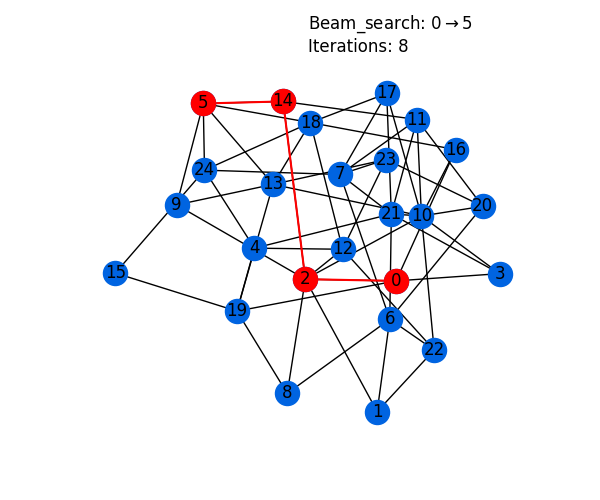

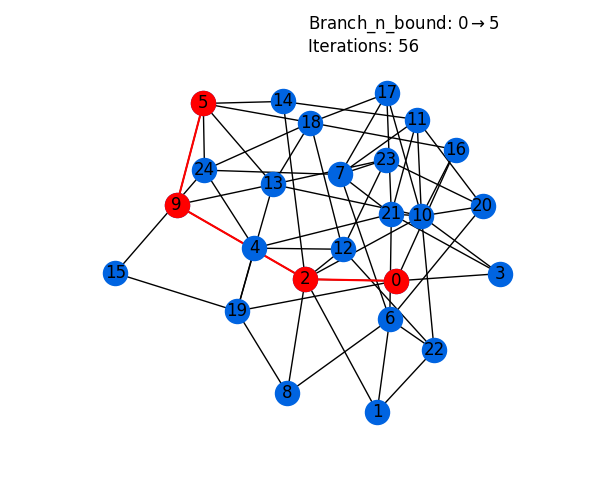

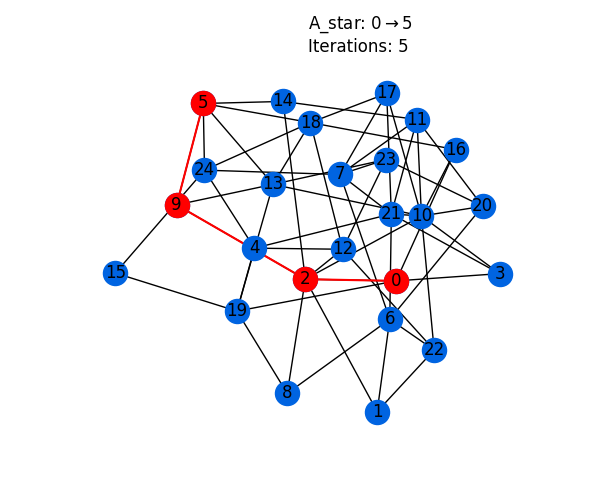

In [31]:
searching_animations = {
    "dfs": dfs,                                     # dfs(G, start, end)
    "bfs": bfs,                                     # bfs(G, start, end)
    "hill_climbing": hill_climbing,                 # hill_climbing(G, start, end, heuristic)
    "beam_search": beam_search,                     # beam_search(G, start, end, heuristc, w)
    "branch_n_bound": branch_n_bound,               # branch_n_bound(G, start, end)         # Weighted G
    "A_star": A_star                                # A_start(G, start, end, heuristic)     # Weighted G
}


G = nx.erdos_renyi_graph(25, 0.2, seed=195)
positions = nx.spring_layout(G, seed=123)    
start, end = 0, 5


def cartesian_distance(node_positions, end, node):
    node_end_vector  = node_positions[end] - node_positions[node]
    return np.sqrt((node_end_vector * node_end_vector).sum())

cartesian_distance = partial(cartesian_distance, positions)

# Weighted Graph: 
# this implementation will use the actual lenght of the path in future examples related to city travelling
# might be usefull to considerated weight[time] = length / allowed_speed
for edge in G.edges():
    distance = cartesian_distance(edge[1], edge[0])
    G.edges[edge]["weight"] = distance

for key, algo in searching_animations.items():
    fig, ax = plt.subplots(figsize=(6, 5))

    explored_paths = algo(G, start, end, heuristic=cartesian_distance, w=2)

    animation = animate_search(
        fig, ax,
        G, positions,
        f"{key.capitalize()}: " + rf"${start} \rightarrow {end}$" + f"\nIterations: {len(explored_paths)}",
        explored_paths,
        interval=200
        )

    animation.save(
        f"./gifs/{key}.gif",
        writer=writer,
        dpi=150
    )
    plt.show()